In [52]:
%matplotlib inline
import numpy as np
import healpy as hp
import astropy.io.fits as fits
import reproject as rp

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


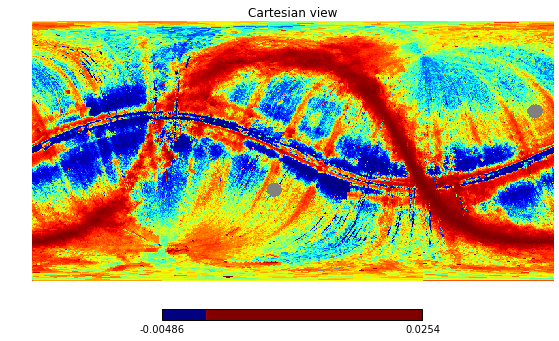

In [53]:
## Read-in the HEALPix map with healpy:
map_Cel = hp.read_map("galaxy_example_128_Cel.fits")

## Visualize the map as-is (without transforming any coordinates!):
##     The 'norm' keyword is just to adjust the color-scale of the visualization. It doesn't affect the output array.

hp.cartview(map_Cel, norm='hist')

## The input map seems to be in celestial coordinates (citing the really curvy Ecliptic and Galactic planes)

(400, 800)
0.000166585434031


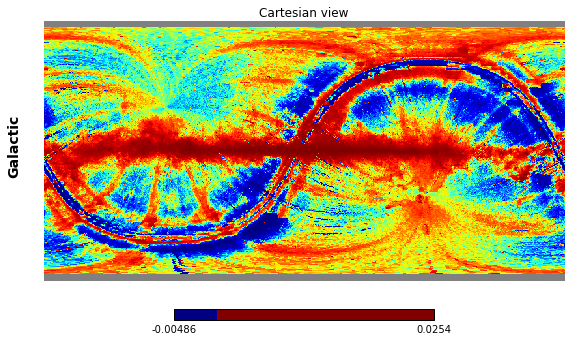

In [54]:
## Convert the healpix map into a Cartesian array, using cartview: 
##     Choose X-size to be your desired array width. By default, cartview sets the y-size to half of x-size.
##     I chose xsize so that the array covers the entire sky, assuming the average pixel-spacing at NSIDE 128 (0.4581 deg)
##     Thus: 360/0.4581 = ~785.85 pixels along the GLON direction. However, I don't want to lose any sky-coverage
##     I'm not sure if this is the best way, but I round up to 800 pixels, and then adjust the pixel-scale accordingly
##     Pixel-scale is specified in the step after this one (making a template header)
##


map_Gal = hp.cartview(map_Cel, coord=['C','G'], return_projected_map=True, xsize=800, norm='hist',nest=False)

## You can see that the winding, wild Milky Way from the image above, as been tamed...
## Ok, conversion to Galactic coordinates seems successful. So far so good.


print np.shape(map_Gal)
print np.nanmean(map_Gal)

In [55]:
## Make a template header for the cartesian array that you just made with cartview
##    You won't actually be using this header to make a cartesian FITS file
##    It's just used for telling reproject.reproject_to_healpix the array's shape, coord system, etc.
##    If it's an all-sky Gal-coord image, set the pixel scale so that pixel-scale * NAXIS1 = 360.0, and 
##    pixel-scale * NAXIS2 is 180.0
##
## The example header here makes a map with a pixel-scale of 0.45-deg by 0.45-deg (Assuming I'm not stupid...)
##     Specify the CTYPE to be the same projection type which you used in healpy:
##     I used cartview, so CTYPE is set to GL**-CAR. For mollview, use ****-MOL.
##     The center of the image is set to be GLON, GLAT = (0,0)

target_header = fits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  800
NAXIS2  =                  400
CTYPE1  = 'GLON-CAR'
CRPIX1  =                  400
CRVAL1  =                  0.0
CDELT1  =                 -0.450000
CUNIT1  = 'deg     '
CTYPE2  = 'GLAT-CAR'
CRPIX2  =                  200
CRVAL2  =                  0.0
CDELT2  =                  0.4500000
CUNIT2  = 'deg     '
COORDSYS= 'GALACTIC'
""", sep='\n')                            


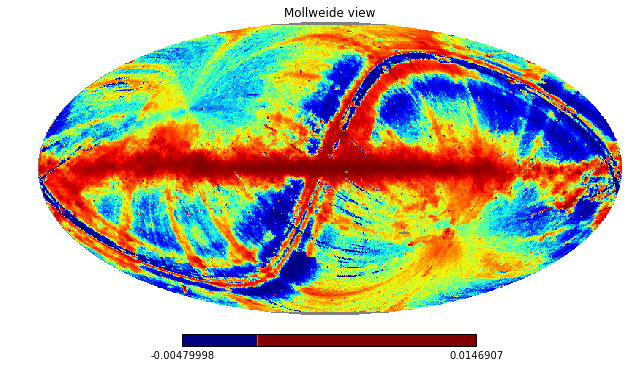

In [56]:
## Now that you've done the rotation/transformation, put the array back into healpix. That's where reproject_to_healpix comes in:
##     I used an NSIDE that matches the input HEALPix map. 
##     target_header is the template header we wrote above.

map_Gal_HP, footprint_Gal_HP = rp.reproject_to_healpix((map_Gal, target_header), coord_system_out= 'GALACTIC', nside=128, nested=False)

# We won't use the footprint here. If you give reproject only one variable to unpack, it'll make a two-column HEALPix map
# The first column will be the data, the 2nd will be the footprint. Be careful!

## Now just write the HEALPix array to a FITS file (if that's what you need). 
##     Be sure to set coord = your new coordinate system ('C','G','E') (assuming you transformed coordiantes)
##     write_map doesn't transform coordinates, so coord has to match that of the input array.
##     In my case, an 'extra' column appeared in my HEALPix array... I only needed the first one
##     You can ignore any unneeded columns by referring specifically to the one you want, hence the '[0]' suffix on the array name

hp.write_map("galaxy_example_128_Gal.fits",map_Gal_HP, coord='G')

## You should carefully check the output map!! The method here is very hastily thrown together by an extremely lazy person (Me.)
## In fact, go ahead and have a first look at the output array from the example here:

hp.mollview(map_Gal_HP, norm='hist', nest=False) #You don't need the x-size keyword, since you're just having a look